In [ ]:
import tensorflow as tf

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
import yfinance as yf
import random

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from datetime import date, timedelta, datetime
import matplotlib.dates as mdates
import math

In [ ]:
data = yf.Ticker("ETH-USD").history(period='5y')

In [ ]:
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-04-14 00:00:00+00:00,492.579987,512.023987,488.278992,501.477997,1519079936,0.0,0.0
2018-04-15 00:00:00+00:00,502.880005,531.702026,502.880005,531.702026,1726089984,0.0,0.0
2018-04-16 00:00:00+00:00,532.073975,534.197021,500.250000,511.147003,1758979968,0.0,0.0
2018-04-17 00:00:00+00:00,511.144989,518.031006,502.563995,502.894012,1760359936,0.0,0.0
2018-04-18 00:00:00+00:00,503.308990,525.091980,503.045013,524.789001,1762940032,0.0,0.0
...,...,...,...,...,...,...,...
2023-04-10 00:00:00+00:00,1859.741211,1917.300171,1848.164185,1911.207520,8380134275,0.0,0.0
2023-04-11 00:00:00+00:00,1911.375854,1936.728271,1886.534180,1892.189697,8877222956,0.0,0.0
2023-04-12 00:00:00+00:00,1891.949707,1929.881226,1860.036865,1920.682129,11010714187,0.0,0.0


In [ ]:
def train_test_split(df,window_size,split_ratio):
    X_train = []
    Y_train = []
    X_test = []
    Y_test = []
    window_size = window_size
    split_ratio = split_ratio
    for i in range(window_size, len(df)):
        X = df.iloc[i-window_size:i, :].values
        Y = df.iloc[i, 1]

        if i < len(df) * split_ratio:
            X_train.append(X)
            Y_train.append(Y)
        else:
            X_test.append(X)
            Y_test.append(Y)
    X_train = np.array(X_train)
    Y_train = np.array(Y_train)
    X_test = np.array(X_test)
    Y_test = np.array(Y_test)

    return X_train,Y_train,X_test,Y_test

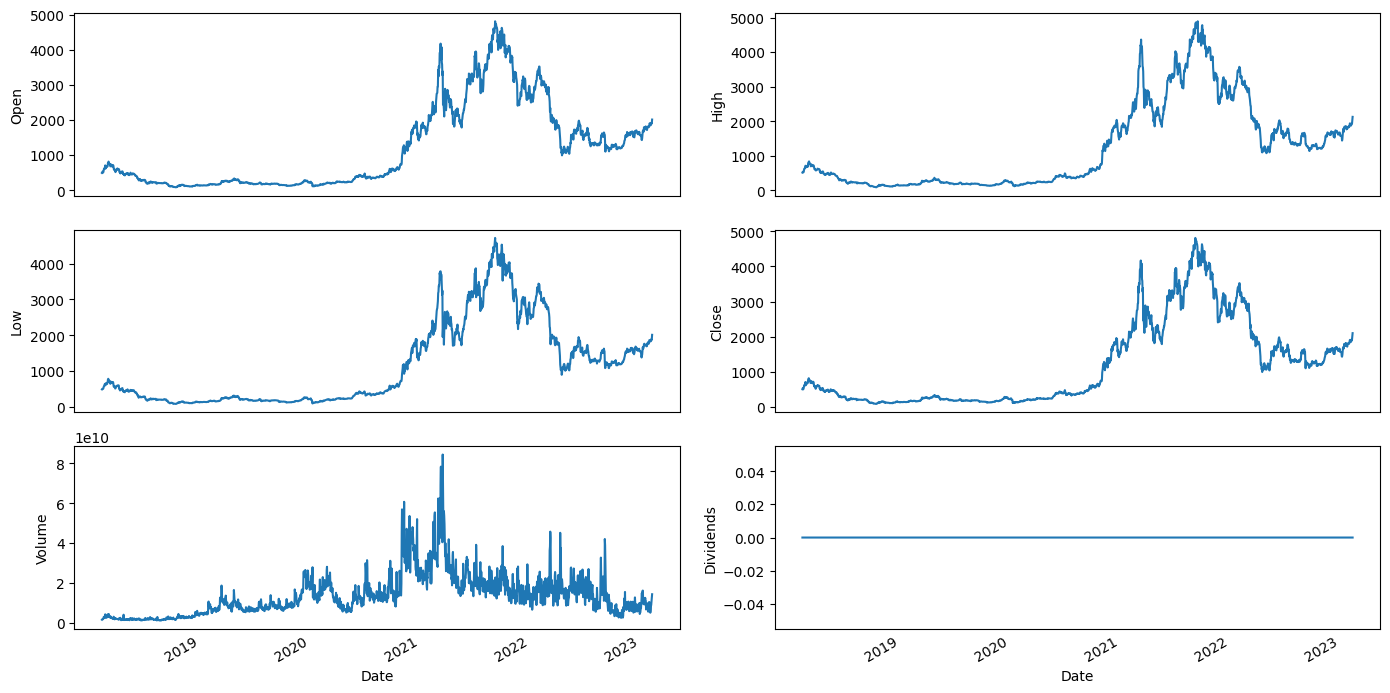

In [ ]:
# Plot line charts
df_plot = data.iloc[:,:6].copy()

ncols = 2
nrows = int(round(df_plot.shape[1] / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
for i, ax in enumerate(fig.axes):
        sbn.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

In [ ]:
train_df = data.sort_values(by=['Date']).copy()

FEATURES = ['High', 'Low', 'Open', 'Close', 'Volume'
            #, 'Month', 'Year', 'Adj Close'
           ]

print('FEATURE LIST')
print([f for f in FEATURES])

data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close']

data_filtered_ext.tail()

FEATURE LIST
['High', 'Low', 'Open', 'Close', 'Volume']


,High,Low,Open,Close,Volume,Prediction
Date,,,,,,
2023-04-10 00:00:00+00:00,1917.300171,1848.164185,1859.741211,1911.207520,8380134275,1911.207520
2023-04-11 00:00:00+00:00,1936.728271,1886.534180,1911.375854,1892.189697,8877222956,1892.189697
2023-04-12 00:00:00+00:00,1929.881226,1860.036865,1891.949707,1920.682129,11010714187,1920.682129
2023-04-13 00:00:00+00:00,2022.150146,1901.860352,1917.698364,2012.634644,12546950499,2012.634644
2023-04-14 00:00:00+00:00,2124.429688,2011.748169,2012.614502,2099.481201,14298307584,2099.481201


In [ ]:
nrows = data_filtered.shape[0]

np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(1827, 5)


In [ ]:
np_data_scaled

array([[0.08877427, 0.08747159, 0.08639829, 0.08823798, 0.00520719],
       [0.09286843, 0.09062161, 0.08857782, 0.09463084, 0.00768938],
       [0.09338753, 0.09005421, 0.0947554 , 0.09028313, 0.00808376],
       ...,
       [0.38377021, 0.38341462, 0.38251158, 0.38842209, 0.11901835],
       [0.40296746, 0.39243762, 0.38796012, 0.4078715 , 0.13743886],
       [0.42424749, 0.41614482, 0.40804483, 0.42624092, 0.15843883]])

In [ ]:
sequence_length = 50

index_Close = data.columns.get_loc("Close")
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:])
        y.append(data[i, index_Close])
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y


x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(1412, 50, 5) (1412,)
(365, 50, 5) (365,)
0.11295381431738685
0.11295381431738685


In [ ]:
# Configure the neural network model
model = Sequential()

n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

250 50 5


In [ ]:
# Training the model
epochs = 50
batch_size = 16
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test)
                   )

                    #callbacks=[early_stop])

Epoch 1/50
89/89 [==============================] - 11s 19ms/step - loss: 0.0041 - val_loss: 0.0023
Epoch 2/50
89/89 [==============================] - 1s 9ms/step - loss: 0.0010 - val_loss: 0.0020
Epoch 3/50
89/89 [==============================] - 1s 9ms/step - loss: 0.0013 - val_loss: 7.1935e-04
Epoch 4/50
89/89 [==============================] - 1s 9ms/step - loss: 0.0014 - val_loss: 8.6450e-04
Epoch 5/50
89/89 [==============================] - 1s 9ms/step - loss: 7.5952e-04 - val_loss: 9.7779e-04
Epoch 6/50
89/89 [==============================] - 1s 10ms/step - loss: 6.5644e-04 - val_loss: 4.6740e-04
Epoch 7/50
89/89 [==============================] - 1s 13ms/step - loss: 6.7019e-04 - val_loss: 3.8272e-04
Epoch 8/50
89/89 [==============================] - 1s 13ms/step - loss: 7.2437e-04 - val_loss: 3.7126e-04
Epoch 9/50
89/89 [==============================] - 1s 9ms/step - loss: 7.1831e-04 - val_loss: 3.7641e-04
Epoch 10/50
89/89 [==============================] - 1s 9ms/step 

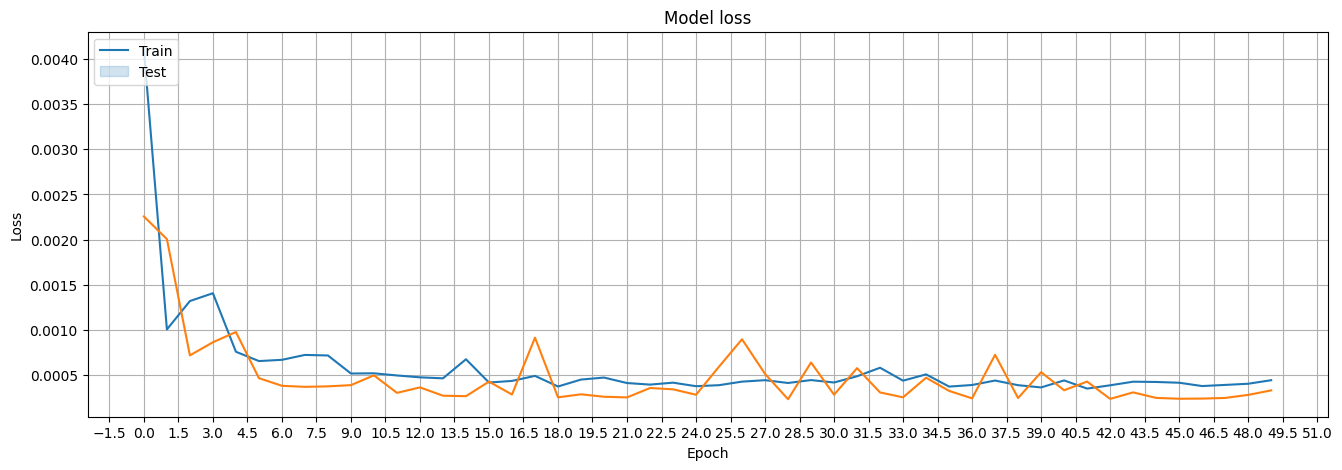

In [ ]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sbn.lineplot(data=history.history["loss"])
sbn.lineplot(data=history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [ ]:
# Get the predicted values
y_pred_scaled = model.predict(x_test)
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

12/12 [==============================] - 0s 11ms/step
Median Absolute Error (MAE): 80.07
Mean Absolute Percentage Error (MAPE): 5.03 %
Median Absolute Percentage Error (MDAPE): 3.92 %


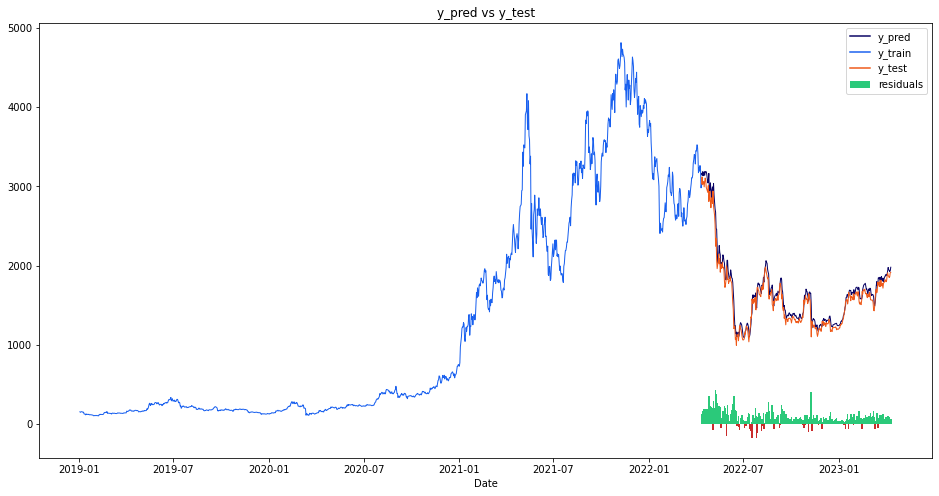

In [ ]:

display_start_date = "2019-01-01"
train = pd.DataFrame(data_filtered_ext['Close'][:train_data_len + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(data_filtered_ext['Close'][train_data_len:]).rename(columns={'Close': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

df_union_zoom = df_union[df_union.index > display_start_date]

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("y_pred vs y_test")

sbn.set_palette(["#090364", "#1960EF", "#EF5919"])
sbn.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
plt.legend()
plt.show()

#Implementation of federated learning

In [ ]:
#splitting the dataset into 5 clients for a a balanced time gap of 5 years

num_clients = 5
client_data = np.array_split(np_data_scaled, num_clients)

In [ ]:
client_data[2].shape

(365, 5)

In [ ]:
#Dividing the close price among the respective clients
close_client_data = np.array_split(np_Close_scaled,num_clients)

In [ ]:
close_client_data[2].shape

(365, 1)

In [ ]:
len(np_data_scaled)

1827

In [ ]:
train_data_len

1462

In [ ]:
train_data_client_len = math.ceil(client_data[0].shape[0] * 0.8)

In [ ]:
#dividing dataset into x_train and y_train
sequence_length = 50
train_per_client={}
test_per_client={}
train_data_client_len = math.ceil(client_data[0].shape[0] * 0.8)

train_data0 = client_data[0][0:train_data_client_len, :]
test_data0 = client_data[0][train_data_client_len - sequence_length:, :]

train_data1 = client_data[1][0:train_data_client_len, :]
test_data1 = client_data[1][train_data_client_len - sequence_length:, :]

train_data2 = client_data[2][0:train_data_client_len, :]
test_data2= client_data[2][train_data_client_len - sequence_length:, :]

train_data3 = client_data[3][0:train_data_client_len, :]
test_data3 = client_data[3][train_data_client_len - sequence_length:, :]

train_data4 = client_data[4][0:train_data_client_len, :]
test_data4 = client_data[4][train_data_client_len - sequence_length:, :]

train_per_client = {'Client_0':train_data0,
                    'Client_1':train_data1,
                    'Client_2':train_data2,
                    'Client_3':train_data3,
                    'Client_4':train_data4}

test_per_client = {'Client_0':test_data0,
                    'Client_1':test_data1,
                    'Client_2':test_data2,
                    'Client_3':test_data3,
                    'Client_4':test_data4}

In [ ]:
len(train_per_client['Client_0'])

293

In [ ]:
len(test_per_client['Client_0'])

123

In [ ]:
X_train0,Y_train0 = partition_dataset(sequence_length,train_per_client['Client_0'])
X_train1,Y_train1 = partition_dataset(sequence_length,train_per_client['Client_1'])
X_train2,Y_train2 = partition_dataset(sequence_length,train_per_client['Client_2'])
X_train3,Y_train3 = partition_dataset(sequence_length,train_per_client['Client_3'])
X_train4,Y_train4 = partition_dataset(sequence_length,train_per_client['Client_4'])


X_test0,Y_test0 = partition_dataset(sequence_length,test_per_client['Client_0'])
X_test1,Y_test1 = partition_dataset(sequence_length,test_per_client['Client_1'])
X_test2,Y_test2 = partition_dataset(sequence_length,test_per_client['Client_2'])
X_test3,Y_test3 = partition_dataset(sequence_length,test_per_client['Client_3'])
X_test4,Y_test4 = partition_dataset(sequence_length,test_per_client['Client_4'])

In [ ]:
X_train0.shape

(243, 50, 5)

In [ ]:
X_test0.shape

(73, 50, 5)

In [ ]:
Y_train0.shape

(243,)

In [ ]:

# Function for creating for model for different
def Create_model(x_train12):
    model = Sequential()
    n_neurons = x_train12.shape[1] * x_train12.shape[2]
    model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train12.shape[1], x_train12.shape[2])))
    model.add(LSTM(n_neurons, return_sequences=False))
    model.add(Dense(5))
    model.add(Dense(1))

    return model


In [ ]:
client_models = []

In [ ]:
client_models.append(Create_model(X_train0))
client_models.append(Create_model(X_train1))
client_models.append(Create_model(X_train2))
client_models.append(Create_model(X_train3))
client_models.append(Create_model(X_train4))

In [ ]:
client_models

In [ ]:
for i in range(num_clients):
    client_models[i].compile(optimizer='adam', loss='mse')

In [ ]:
epochs = 50
batch_size = 16
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history0 = client_models[0].fit(X_train0, Y_train0,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_test0, Y_test0)
                   )


Epoch 1/50
16/16 [==============================] - 3s 96ms/step - loss: 5.7836e-04 - val_loss: 2.2222e-04
Epoch 2/50
16/16 [==============================] - 0s 24ms/step - loss: 7.5648e-05 - val_loss: 1.3833e-05
Epoch 3/50
16/16 [==============================] - 0s 25ms/step - loss: 3.5237e-05 - val_loss: 1.8465e-05
Epoch 4/50
16/16 [==============================] - 0s 24ms/step - loss: 3.3227e-05 - val_loss: 2.8919e-05
Epoch 5/50
16/16 [==============================] - 0s 24ms/step - loss: 3.3212e-05 - val_loss: 3.5853e-05
Epoch 6/50
16/16 [==============================] - 0s 26ms/step - loss: 3.5703e-05 - val_loss: 8.6560e-06
Epoch 7/50
16/16 [==============================] - 0s 23ms/step - loss: 3.2194e-05 - val_loss: 2.4573e-05
Epoch 8/50
16/16 [==============================] - 0s 23ms/step - loss: 3.2059e-05 - val_loss: 1.2140e-05
Epoch 9/50
16/16 [==============================] - 0s 23ms/step - loss: 2.8646e-05 - val_loss: 7.6391e-06
Epoch 10/50
16/16 [==================

In [ ]:
history1 = client_models[1].fit(X_train1, Y_train1,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_test1, Y_test1)
                   )

Epoch 1/50
16/16 [==============================] - 2s 56ms/step - loss: 5.8915e-04 - val_loss: 1.4831e-04
Epoch 2/50
16/16 [==============================] - 0s 26ms/step - loss: 6.5856e-05 - val_loss: 6.6512e-05
Epoch 3/50
16/16 [==============================] - 0s 26ms/step - loss: 2.8948e-05 - val_loss: 4.3337e-05
Epoch 4/50
16/16 [==============================] - 0s 24ms/step - loss: 1.9230e-05 - val_loss: 5.6016e-05
Epoch 5/50
16/16 [==============================] - 0s 24ms/step - loss: 1.4155e-05 - val_loss: 4.5749e-05
Epoch 6/50
16/16 [==============================] - 0s 25ms/step - loss: 1.5310e-05 - val_loss: 5.0324e-05
Epoch 7/50
16/16 [==============================] - 0s 24ms/step - loss: 1.3381e-05 - val_loss: 4.5036e-05
Epoch 8/50
16/16 [==============================] - 0s 23ms/step - loss: 1.6391e-05 - val_loss: 4.2737e-05
Epoch 9/50
16/16 [==============================] - 0s 23ms/step - loss: 1.4864e-05 - val_loss: 5.0328e-05
Epoch 10/50
16/16 [==================

In [ ]:
history2 = client_models[2].fit(X_train2, Y_train2,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_test2, Y_test2)
                   )

Epoch 1/50
16/16 [==============================] - 2s 70ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 2/50
16/16 [==============================] - 0s 26ms/step - loss: 4.1665e-04 - val_loss: 0.0012
Epoch 3/50
16/16 [==============================] - 0s 25ms/step - loss: 2.0709e-04 - val_loss: 0.0018
Epoch 4/50
16/16 [==============================] - 0s 27ms/step - loss: 1.6347e-04 - val_loss: 0.0023
Epoch 5/50
16/16 [==============================] - 0s 25ms/step - loss: 1.4863e-04 - val_loss: 0.0019
Epoch 6/50
16/16 [==============================] - 0s 24ms/step - loss: 1.5616e-04 - val_loss: 0.0012
Epoch 7/50
16/16 [==============================] - 0s 27ms/step - loss: 1.5947e-04 - val_loss: 0.0013
Epoch 8/50
16/16 [==============================] - 0s 25ms/step - loss: 1.9396e-04 - val_loss: 0.0020
Epoch 9/50
16/16 [==============================] - 0s 24ms/step - loss: 2.8646e-04 - val_loss: 0.0010
Epoch 10/50
16/16 [==============================] - 0s 26ms/step - loss: 1.6

In [ ]:
history3 = client_models[3].fit(X_train3, Y_train3,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_test3, Y_test3)
                   )

Epoch 1/50
16/16 [==============================] - 3s 79ms/step - loss: 0.0476 - val_loss: 0.0027
Epoch 2/50
16/16 [==============================] - 0s 28ms/step - loss: 0.0049 - val_loss: 0.0025
Epoch 3/50
16/16 [==============================] - 0s 28ms/step - loss: 0.0034 - val_loss: 0.0021
Epoch 4/50
16/16 [==============================] - 0s 32ms/step - loss: 0.0029 - val_loss: 0.0019
Epoch 5/50
16/16 [==============================] - 1s 32ms/step - loss: 0.0029 - val_loss: 0.0022
Epoch 6/50
16/16 [==============================] - 0s 28ms/step - loss: 0.0028 - val_loss: 0.0020
Epoch 7/50
16/16 [==============================] - 0s 27ms/step - loss: 0.0026 - val_loss: 0.0020
Epoch 8/50
16/16 [==============================] - 0s 27ms/step - loss: 0.0030 - val_loss: 0.0021
Epoch 9/50
16/16 [==============================] - 0s 27ms/step - loss: 0.0027 - val_loss: 0.0017
Epoch 10/50
16/16 [==============================] - 0s 27ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 11/

In [ ]:
history4 = client_models[4].fit(X_train4, Y_train4,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_test4, Y_test4)
                   )

Epoch 1/50
16/16 [==============================] - 3s 88ms/step - loss: 0.0082 - val_loss: 0.0030
Epoch 2/50
16/16 [==============================] - 1s 34ms/step - loss: 0.0012 - val_loss: 4.6202e-04
Epoch 3/50
16/16 [==============================] - 0s 28ms/step - loss: 8.8583e-04 - val_loss: 2.6817e-04
Epoch 4/50
16/16 [==============================] - 0s 30ms/step - loss: 7.1791e-04 - val_loss: 3.5572e-04
Epoch 5/50
16/16 [==============================] - 0s 29ms/step - loss: 6.7674e-04 - val_loss: 4.2388e-04
Epoch 6/50
16/16 [==============================] - 0s 29ms/step - loss: 6.9450e-04 - val_loss: 3.7226e-04
Epoch 7/50
16/16 [==============================] - 0s 30ms/step - loss: 7.1510e-04 - val_loss: 2.6024e-04
Epoch 8/50
16/16 [==============================] - 1s 33ms/step - loss: 5.8978e-04 - val_loss: 7.3007e-04
Epoch 9/50
16/16 [==============================] - 1s 32ms/step - loss: 6.2933e-04 - val_loss: 2.4225e-04
Epoch 10/50
16/16 [==============================

In [ ]:
client_models[4].get_weights()

[array([[-0.00177727,  0.05322822,  0.06430543, ..., -0.02311202,
          0.03313224,  0.16992362],
        [-0.00881971, -0.01994726,  0.05086062, ...,  0.00606328,
          0.00261706,  0.17736869],
        [ 0.05803984,  0.00886555,  0.04894459, ...,  0.02772369,
         -0.01671981,  0.08490729],
        [ 0.03599497,  0.05295391,  0.05666005, ...,  0.10501836,
          0.00949933,  0.12742674],
        [ 0.11130574,  0.02922641, -0.08210246, ..., -0.04082261,
          0.03955967,  0.073297  ]], dtype=float32),
 array([[ 0.00294073, -0.00372763,  0.00417648, ...,  0.00121394,
          0.01215563, -0.02326481],
        [ 0.02271939, -0.03464186,  0.00156939, ..., -0.02718589,
          0.04172274, -0.02748093],
        [ 0.00163709,  0.00104505, -0.0151242 , ..., -0.02941051,
         -0.02202581, -0.03726109],
        ...,
        [ 0.06250738,  0.02053119, -0.02151662, ...,  0.00994247,
         -0.06465961,  0.00136884],
        [-0.03742554, -0.00412476, -0.04851554, ...,

In [ ]:
client_weights = []
for i in range(num_clients):
    x = client_models[i].get_weights()
    client_weights.append(x)


In [ ]:
global_weights = []

In [ ]:
global_weights = np.average(client_weights,axis=0)

In [ ]:
global_weights

array([array([[ 0.00556696,  0.002804  ,  0.01285627, ..., -0.03208438,
               -0.01309684,  0.04066458],
              [ 0.04820807, -0.00495368,  0.00774567, ...,  0.03213941,
               -0.00513984,  0.02708525],
              [ 0.01486994, -0.00303399,  0.03604151, ..., -0.02118015,
                0.02519675,  0.00223001],
              [ 0.01608901,  0.00494766,  0.02845728, ...,  0.03888564,
                0.01623165,  0.0304573 ],
              [-0.00904378,  0.01759033,  0.01047637, ..., -0.0031989 ,
                0.01015604,  0.02768255]], dtype=float32)              ,
       array([[-0.00309547, -0.00409281,  0.00117804, ..., -0.00408051,
                0.02748164,  0.0033827 ],
              [-0.00558259,  0.00404948,  0.00329606, ...,  0.00160323,
                0.00341574, -0.00778155],
              [ 0.00147173, -0.01065984,  0.00249911, ...,  0.0052982 ,
               -0.0111393 , -0.01024659],
              ...,
              [ 0.01309068,  0.0109052

In [ ]:
for i in range(num_clients):
    client_models[i].set_weights(global_weights)

In [ ]:
client_models[4].get_weights()

[array([[ 0.00556696,  0.002804  ,  0.01285627, ..., -0.03208438,
         -0.01309684,  0.04066458],
        [ 0.04820807, -0.00495368,  0.00774567, ...,  0.03213941,
         -0.00513984,  0.02708525],
        [ 0.01486994, -0.00303399,  0.03604151, ..., -0.02118015,
          0.02519675,  0.00223001],
        [ 0.01608901,  0.00494766,  0.02845728, ...,  0.03888564,
          0.01623165,  0.0304573 ],
        [-0.00904378,  0.01759033,  0.01047637, ..., -0.0031989 ,
          0.01015604,  0.02768255]], dtype=float32),
 array([[-0.00309547, -0.00409281,  0.00117804, ..., -0.00408051,
          0.02748164,  0.0033827 ],
        [-0.00558259,  0.00404948,  0.00329606, ...,  0.00160323,
          0.00341574, -0.00778155],
        [ 0.00147173, -0.01065984,  0.00249911, ...,  0.0052982 ,
         -0.0111393 , -0.01024659],
        ...,
        [ 0.01309068,  0.01090528, -0.01735948, ...,  0.003953  ,
         -0.00204953,  0.01403477],
        [-0.01995485, -0.01328884, -0.01741299, ...,

In [ ]:
import psutil

In [ ]:
cpu_percent = psutil.cpu_percent()

In [ ]:
cpu_percent

21.1